# Data extraction

## Libraries

In [89]:
import os
os.environ['TF_GPU_THREAD_COUNT'] = '5'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
import time
import numpy as np
from joblib import Parallel, delayed
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
import setuptools.dist
from collections import Counter
from skimage.transform import resize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
import scipy
from scipy.signal import butter, filtfilt
import pywt
import tensorflow as tf
import itertools
import seaborn as sns
import tensorflow.python.keras.backend as K
import tsaug as ts
from scipy.ndimage import gaussian_filter
from finta import TA

## Magical formulas to use .mat files

In [39]:
n_subjects = 10
files = [f"S{x}" for x in range(1, n_subjects + 1)]
data = dict()
for file in files:
  E1 = scipy.io.loadmat(f"../data/{file}/{file}_E1_A1.mat")  # Exercise A
  E2 = scipy.io.loadmat(f"../data/{file}/{file}_E2_A1.mat")  # Exercise B
  E3 = scipy.io.loadmat(f"../data/{file}/{file}_E3_A1.mat")  # Exercise C

  # Movimento 0 é o movimento de repouso, então é subtraído 12 e 29 para os experimentos 2 e 3
  E2["stimulus"][np.where(E2["stimulus"] == 0)] = E2["stimulus"][np.where(E2["stimulus"] == 0)] - 12
  E3["stimulus"][np.where(E3["stimulus"] == 0)] = E3["stimulus"][np.where(E3["stimulus"] == 0)] - 29

  data[file] = {
    'emg': np.concatenate([E1["emg"], E2['emg'], E3['emg']]),
    'label': np.concatenate([E1["stimulus"], E2["stimulus"] + 12, E3["stimulus"] + 29]),
    'info': {
      'age': E1['age'],
      'gender': E1['gender'],
      'n_subjects': 10,
      'weight': E1['weight'],
      'height': E1['height'],
      'fs': E1["frequency"][0][0]
    },
    'description': "Contiene datos de EMG de 10 sujetos, 3 experimentos por cada sujeto (E1, E2 y E3) (A, B y C de la figura), cada experimento contiene diferentes ejercicios (A:12, B:17, C:23)."
  }

# Adicionando os dados em um dataframe
df = pd.DataFrame.from_dict(data, orient='index')
print(df)

                                                   emg  \
S1   [[-22.0, -2.0, -16.0, -7.0, -3.0, -1.0, -2.0, ...   
S2   [[-5.0, -1.0, -2.0, -2.0, 1.0, -2.0, 1.0, -3.0...   
S3   [[-5.0, -4.0, -2.0, -1.0, -2.0, -1.0, 0.0, -2....   
S4   [[0.0, -3.0, 1.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1.0...   
S5   [[-2.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 1.0, ...   
S6   [[6.0, -1.0, -2.0, -2.0, 0.0, -1.0, -1.0, -1.0...   
S7   [[-1.0, -2.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0,...   
S8   [[-1.0, -2.0, 1.0, 0.0, 0.0, 0.0, 1.0, -1.0, -...   
S9   [[-2.0, -2.0, 0.0, -1.0, 0.0, -1.0, 0.0, -2.0,...   
S10  [[0.0, -1.0, -1.0, -2.0, -6.0, -4.0, -2.0, 2.0...   

                                                 label  \
S1   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S2   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S3   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S4   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S5   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
S6   [[0], [0

In [4]:
df.head()

,emg,label,info,description
S1,"[[-22.0, -2.0, -16.0, -7.0, -3.0, -1.0, -2.0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[23]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S2,"[[-5.0, -1.0, -2.0, -2.0, 1.0, -2.0, 1.0, -3.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S3,"[[-5.0, -4.0, -2.0, -1.0, -2.0, -1.0, 0.0, -2....","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['m'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S4,"[[0.0, -3.0, 1.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1.0...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[22]], 'gender': ['f'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."
S5,"[[-2.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 1.0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","{'age': [[28]], 'gender': ['f'], 'n_subjects':...","Contiene datos de EMG de 10 sujetos, 3 experim..."


## functions used to get some info

In [49]:
def _rms(data):
	"""
	Root Mean Square.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: RMS feature.
	"""
	return np.sqrt(np.mean(data**2, axis=0))

def _zc(data):
	"""
	Zero Crossing.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: ZC feature.
	"""
	return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0)

def _var(data):
	"""
	Variance.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: Variance feature.
	"""
	return np.var(data, axis=0)

def _mav(data):
	"""
	Mean Absolute Value.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: MAV feature.
	"""
	return np.mean(np.abs(data), axis=0)

def _sscl(data):
	"""
	Slope Sign Change List.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: SSC feature.
	"""
	diff_signal = np.diff(data)
	sign_changes = np.diff(np.sign(diff_signal))
 
	return np.sum(np.abs(np.diff(data, axis=0)), axis=0)

def _wl(data):
	"""
	Waveform Length.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: WL feature.
	"""
	return np.sum(np.abs(np.diff(data, axis=0)), axis=0)


def _hrm(emg_data):
	"""
	Waveform Length.

	Arguments:
			@var emg_data: list of graph data. 

	Returns:
			@return: HRM feature.
	"""

	return np.mean(np.sqrt(np.abs(emg_data)), axis=0)


#### Faltam testes com a ren com os parâmetros ideais
def _ren(data, m=100, tolerance=50):
    n = len(data)
    
    # Verificar se o comprimento dos dados permite a execução
    if n < m:
        return 0
    
    # Cria uma matriz com todos os segmentos de tamanho `m`
    segments = np.array([data[i:i + m] for i in range(n - m + 1)])
    
    # Calcula as diferenças absolutas entre todos os pares de segmentos
    diffs = np.abs(segments[:, np.newaxis] - segments)
    # Verifica se todas as diferenças dentro de cada par são <= tolerance
    matches = np.all(diffs <= tolerance, axis=2)
    
    # Conta as correspondências, subtrai 1 para não contar o próprio segmento
    count = np.sum(matches) - (n - m + 1)
    
    # Calcula o número total de combinações possíveis
    total_combinations = (n - m) * (n - m + 1) / 2
    
    # Calcula a entropia aproximada
    rough_entropy_value = -np.log(count / total_combinations) if count > 0 else 0
    return rough_entropy_value

### Signal filters

#### Butterworth bandpass

In [5]:
def butterworth_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butterworth_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#### Wavelet transform

In [6]:
def wavelet_transform(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

## Training dataset

### Extract features

In [64]:
def mk_features(emg_df):
    ftrs = ['rms', 'zc', 'var', 'mav', 'sscl', 'wl', 'hrm']
    n_channels = 16
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in ftrs]
    columns.append('label')
    features_df = pd.DataFrame(columns=columns)
    
    def process(window, n_channels=16):
        row = {}
        label = np.array(window['label'])
        mostCommonLabel = Counter(label.flatten().astype(int).tolist()).most_common(1)[0][0]
    
        for i in range(n_channels):
            channel_data = window[f'emg_{i+1}']
    
            rms = _rms(channel_data)
            zc = _zc(channel_data)
            var = _var(channel_data)
            mav = _mav(channel_data)
            sscl = _sscl(channel_data)
            wl = _wl(channel_data)
            hrm = _hrm(channel_data)
    
            row[f'rms_{i+1}'] = rms
            row[f'zc_{i+1}'] = zc
            row[f'var_{i+1}'] = var
            row[f'mav_{i+1}'] = mav
            row[f'sscl_{i+1}'] = sscl
            row[f'wl_{i+1}'] = wl
            row[f'hrm_{i+1}'] = hrm
    
        row['label'] = mostCommonLabel
        return row
    
    window_size = 200
    step = 25
    windows = emg_df.rolling(window=window_size, step=step)
    results = Parallel(n_jobs=-1)(delayed(process)(window, n_channels=n_channels) for window in windows if len(window) == window_size)
    
    return pd.DataFrame(results, columns=columns)

In [51]:
emg_data = []
for index, row in df.iterrows():
    for i, emg in enumerate(row['emg']):
        emg_data.append({ 'emg': emg, 'label': row['label'][i] })

In [65]:
emg_df = pd.DataFrame(emg_data)

# adicionar colunas separadas para cada canal de EMG
for i in range(16):
    emg_df[f'emg_{i+1}'] = emg_df['emg'].apply(lambda x: x[i] if i < len(x) else np.nan)

# remover a coluna original 'emg'
emg_df.drop(columns=['emg'], inplace=True)

features_df = mk_features(emg_df)
features_df.head()

,rms_1,zc_1,var_1,mav_1,sscl_1,wl_1,hrm_1,rms_2,zc_2,var_2,...,wl_15,hrm_15,rms_16,zc_16,var_16,mav_16,sscl_16,wl_16,hrm_16,label
0,10.748721,115,115.023773,6.685,2096.0,2096.0,2.187962,19.061743,123,361.910004,...,556.0,1.203651,6.166847,98,36.948399,4.270,1175.0,1175.0,1.779411,0
1,9.144124,116,83.359978,5.395,1665.0,1665.0,1.943728,9.358151,118,86.958778,...,322.0,1.033981,5.523133,93,29.919775,3.845,937.0,937.0,1.681454,0
2,7.553476,114,56.340977,4.175,1232.0,1232.0,1.681269,7.719132,118,59.044773,...,291.0,0.972428,4.930517,98,23.500000,3.380,783.0,783.0,1.554758,0
3,5.574047,111,30.277901,3.330,952.0,952.0,1.542950,6.489222,122,41.149601,...,280.0,0.971386,4.307551,94,17.680775,3.035,624.0,624.0,1.480748,0
4,5.502272,114,29.594376,3.225,914.0,914.0,1.506509,5.808184,122,32.600777,...,260.0,0.950279,3.952847,93,14.574375,2.765,583.0,583.0,1.413978,0


### Train and test cases

#### Cross-validation test

In [68]:
# Make the cross-validation of train data
def cross_validation(model, X, y, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    return scores

# Train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Train and evaluate the model with cross-validation
def train_and_evaluate_model_cv(model, X, y, cv=5):
    scores = cross_validation(model, X, y, cv=cv)
    return

### Using ML techniques

In [77]:
ml_df = features_df.copy()
X = ml_df.drop(columns=['label'])
y = ml_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     20469
           1       0.83      0.70      0.76       550
           2       0.93      0.62      0.74       598
           3       0.86      0.76      0.81       584
           4       0.93      0.60      0.73       637
           5       0.91      0.73      0.81       590
           6       0.93      0.60 

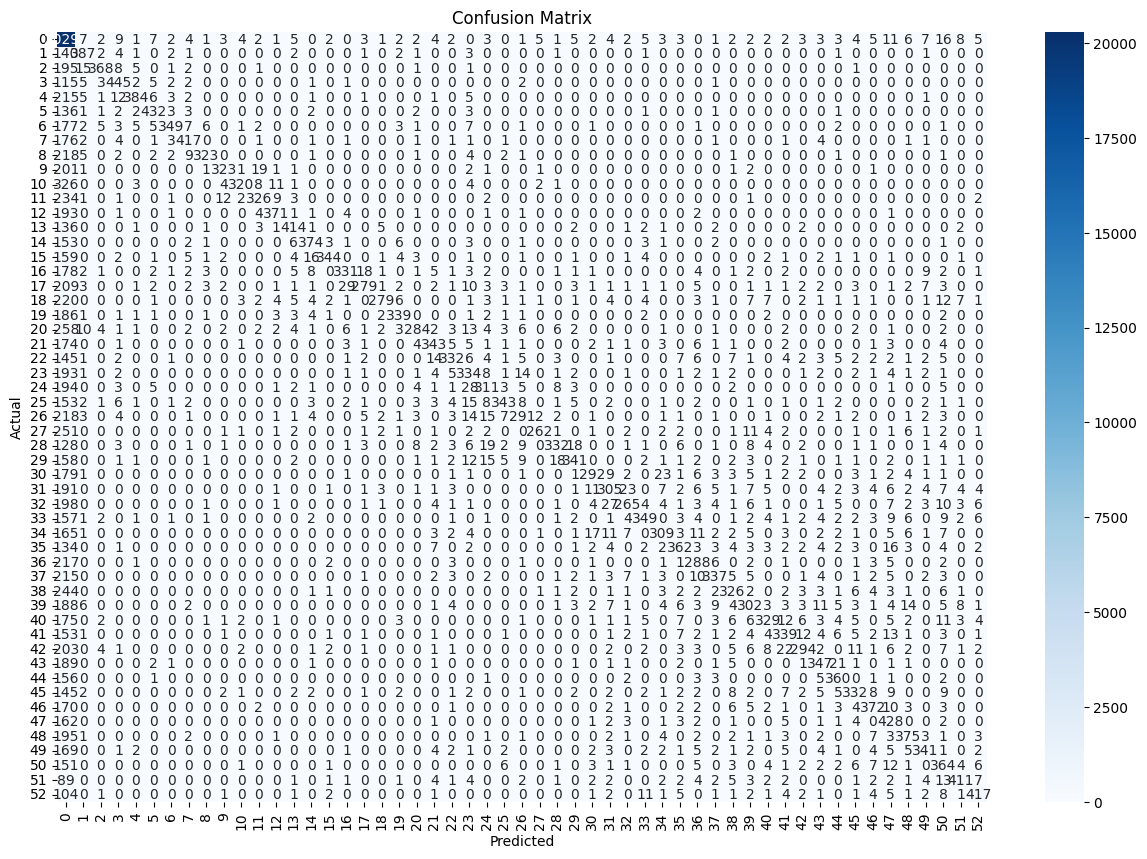

In [85]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
train_and_evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

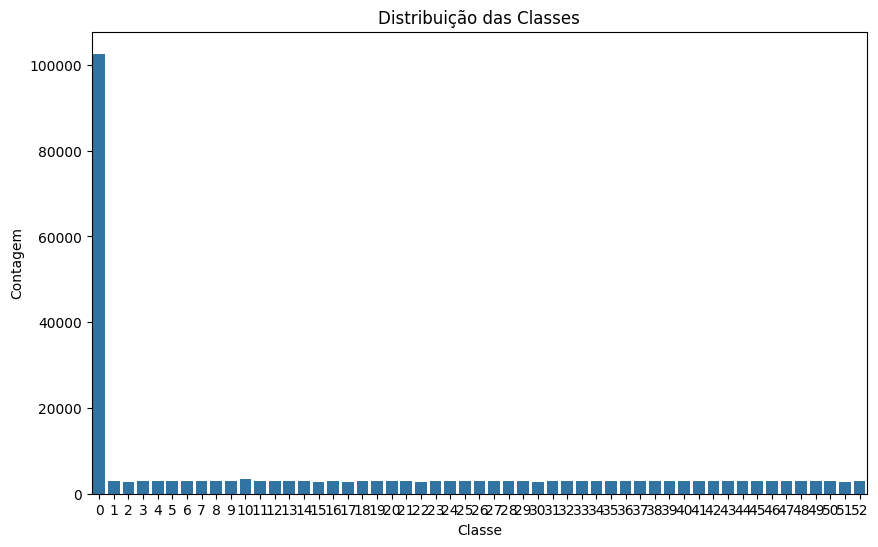

In [86]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=features_df)
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()


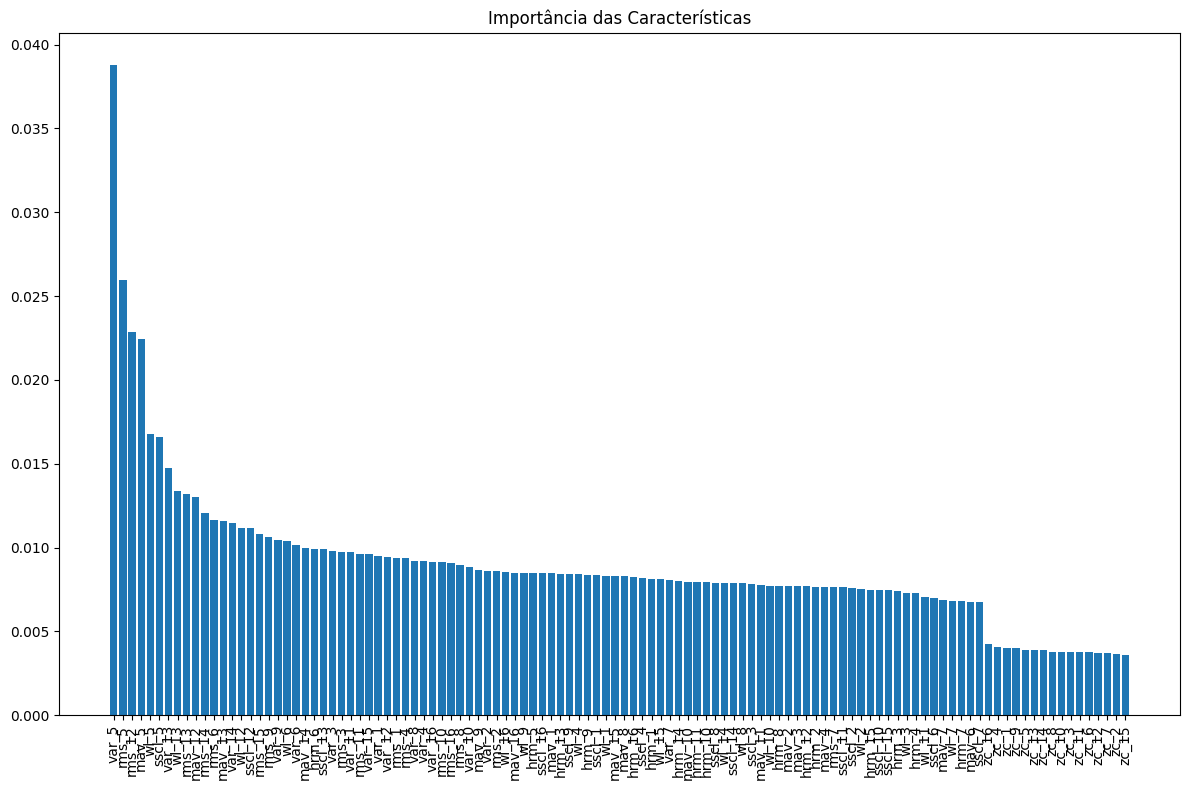

In [87]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 8))
plt.title('Importância das Características')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

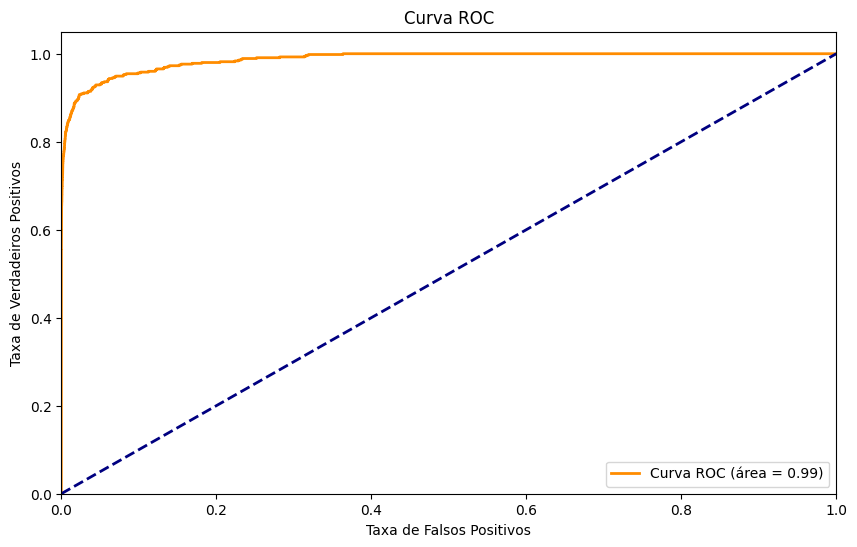

In [90]:
# 3. Curva ROC e AUC
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=best_model.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

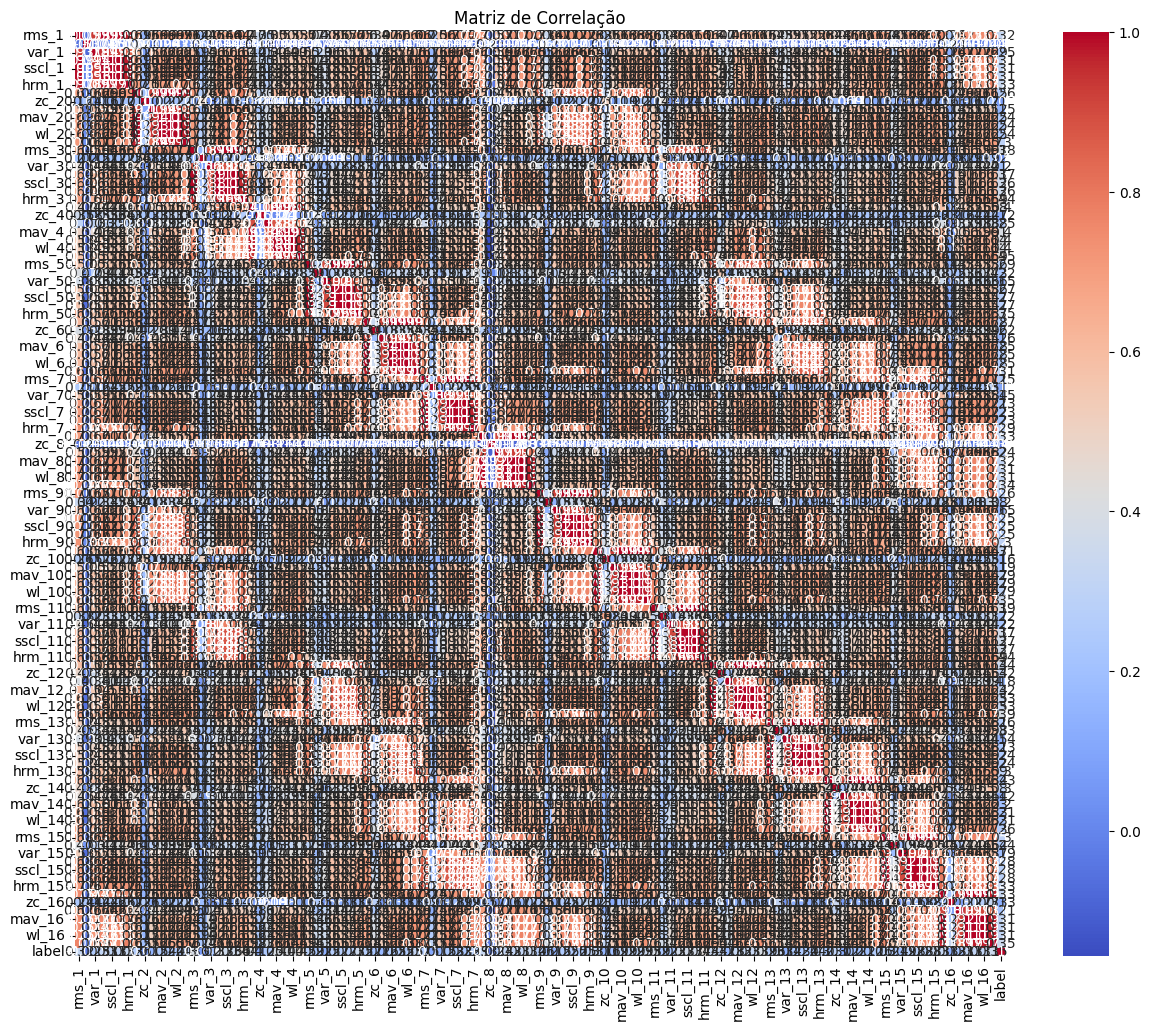

In [93]:
plt.figure(figsize=(15, 12))
correlation_matrix = features_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

### Using DL techniques

In [ ]:
dl_df = features_df.copy()
X = dl_df.drop(columns=['label'])
y = dl_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
y_train_parsed = keras.utils.to_categorical(y_train, num_classes=36)
y_test_parsed = keras.utils.to_categorical(y_test, num_classes=36)

model = keras.models.Sequential()
model.add(keras.layers.Dense(2056, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(1028, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
  X_train,
  y_train_parsed,
  epochs=250,
  batch_size=5500,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plot_residuals(y_test_classes, y_pred_classes)
plot_real_vs_pred(y_test_classes, y_pred_classes)
plot_error_distribution(y_test_classes, y_pred_classes)